Prediction model to predict if the client will subscribe a term deposit or not.

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV 
from time import time
import scikitplot as skplt

Using TensorFlow backend.


In [4]:
df_train = pd.read_csv('train.csv')

In [5]:
df_test = pd.read_csv('test.csv')

In [6]:
df_train.head()

,ID,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed
0,26110,56,admin.,married,unknown,no,1933,no,no,telephone,19,nov,44,2,-1,0,unknown,no
1,40576,31,unknown,married,secondary,no,3,no,no,cellular,20,jul,91,2,-1,0,unknown,no
2,15320,27,services,married,secondary,no,891,yes,no,cellular,18,jul,240,1,-1,0,unknown,no
3,43962,57,management,divorced,tertiary,no,3287,no,no,cellular,22,jun,867,1,84,3,success,yes
4,29842,31,technician,married,secondary,no,119,yes,no,cellular,4,feb,380,1,-1,0,unknown,no


In [7]:
df_test.head()

,ID,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,38441,32,services,married,secondary,no,118,yes,no,cellular,15,may,20,6,-1,0,unknown
1,40403,78,retired,divorced,primary,no,2787,no,no,telephone,1,jul,372,1,-1,0,unknown
2,3709,31,self-employed,single,tertiary,no,144,yes,no,unknown,16,may,676,1,-1,0,unknown
3,37422,57,services,single,primary,no,3777,yes,no,telephone,13,may,65,2,-1,0,unknown
4,12527,45,blue-collar,divorced,secondary,no,-705,no,yes,unknown,3,jul,111,1,-1,0,unknown


In [8]:
df_train.isna().any()

ID            False
age           False
job           False
marital       False
education     False
default       False
balance       False
housing       False
loan          False
contact       False
day           False
month         False
duration      False
campaign      False
pdays         False
previous      False
poutcome      False
subscribed    False
dtype: bool

In [9]:
df_test.isna().any()

ID           False
age          False
job          False
marital      False
education    False
default      False
balance      False
housing      False
loan         False
contact      False
day          False
month        False
duration     False
campaign     False
pdays        False
previous     False
poutcome     False
dtype: bool

Let's begin with EDA

In [10]:
df = pd.concat([df_train, df_test], ignore_index=True, sort=False)

Text(0.5, 1.0, 'Jobs distribution plot')

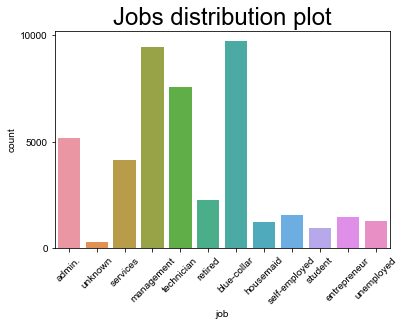

In [11]:
labels = df['job'].unique()
distplot = sns.countplot('job', data=df)
sns.set(rc={'figure.figsize':(10,10)}, font_scale=2)
distplot.set_xticklabels(rotation=45, labels=labels)
plt.title('Jobs distribution plot')

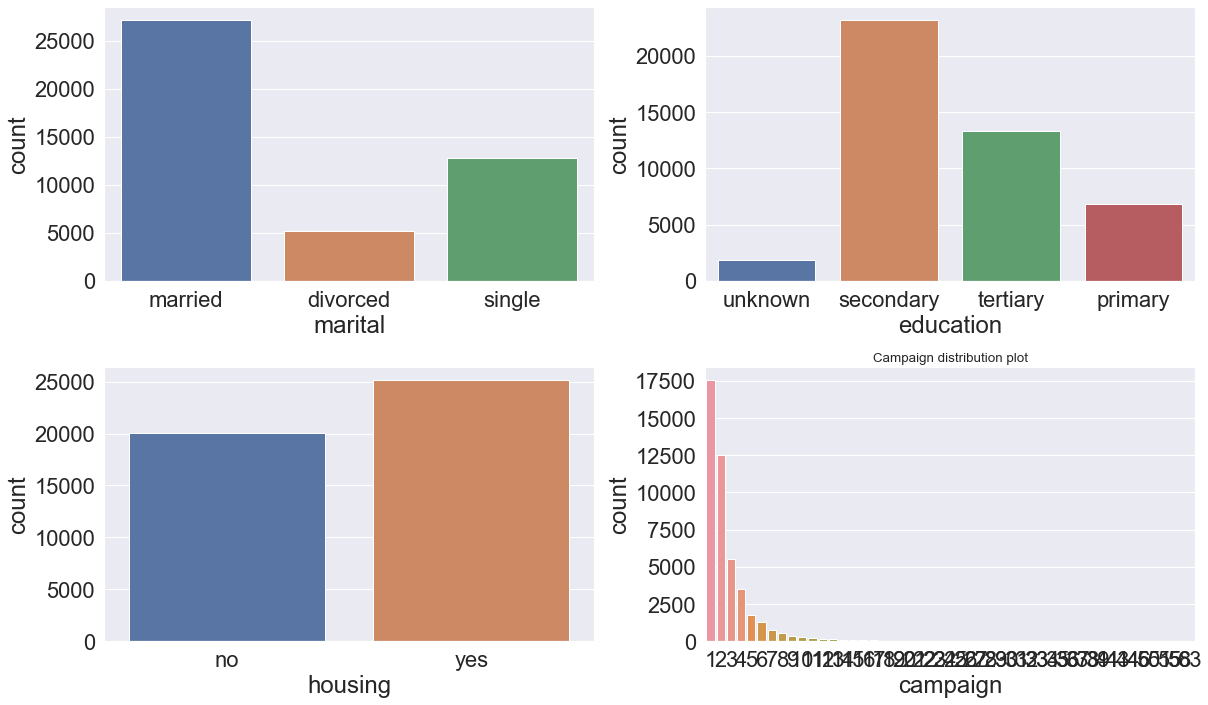

In [12]:
f, ax = plt.subplots(2, 2, figsize=(17, 10))

sns.set(font_scale=1.1125)

distplot.set_xticklabels(rotation=45, labels=labels)
sns.countplot('marital', data=df, ax=ax[0][0])
plt.title('Marital distribution plot')

sns.countplot('education', data=df, ax=ax[0][1])
plt.title('Education distribution plot')

sns.countplot('housing', data=df, ax=ax[1][0])
plt.title('Housing distribution plot')

c_plot = sns.countplot('campaign', data=df, ax=ax[1][1])
plt.title('Campaign distribution plot')

plt.tight_layout()
plt.show()

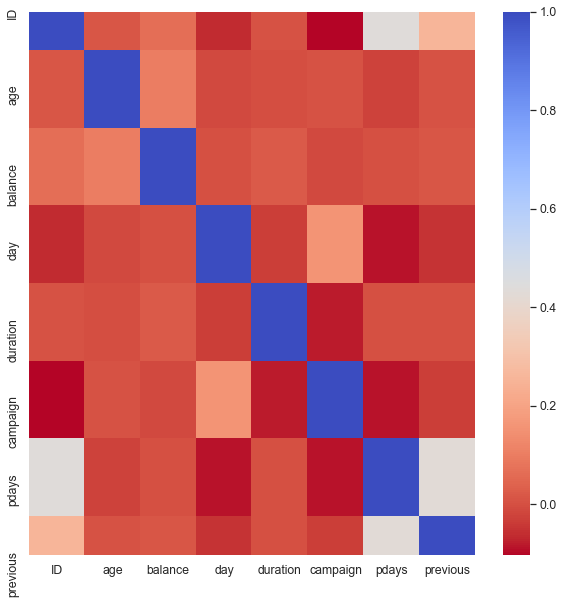

In [14]:
corr = df_train.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':7})
plt.show()

[Text(0, 0, 'balance'),
 Text(0, 0, 'day'),
 Text(0, 0, 'duration'),
 Text(0, 0, 'campaign'),
 Text(0, 0, 'pdays'),
 Text(0, 0, 'previous')]

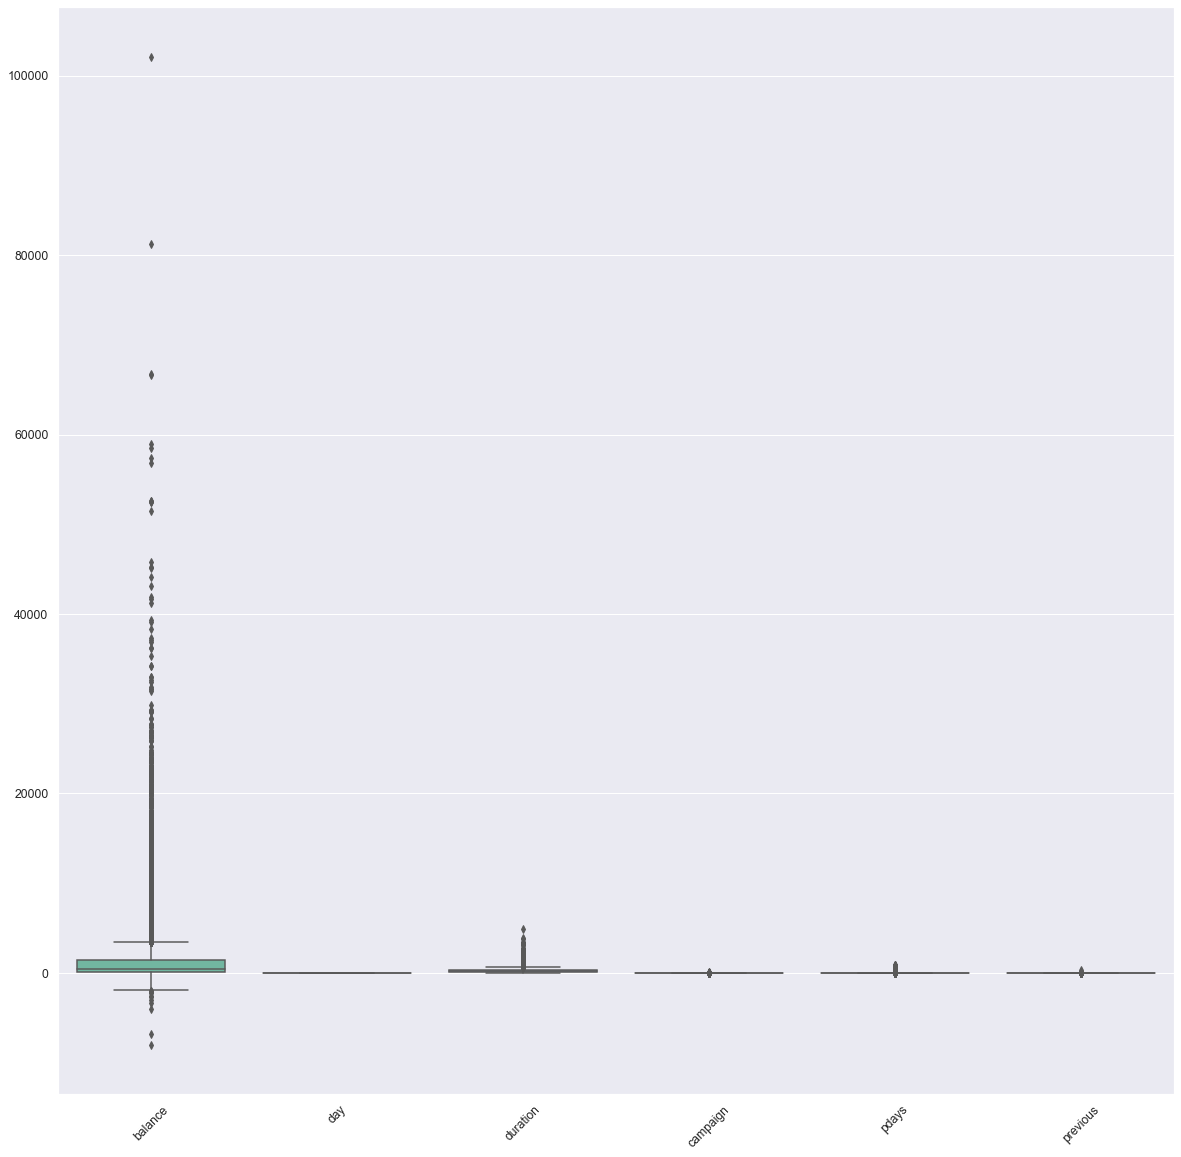

In [15]:
temp = df_train.iloc[:,2:].select_dtypes(include=['int64','float64'])
columns = list(temp.columns.values)
plt.figure(figsize=(20,20))
boxplot = sns.boxplot(data=df_train[columns], palette="Set2")
sns.set(font_scale=1.125)
boxplot.set_xticklabels(rotation=45, labels=temp.columns.values)

No fields, other than balance have significant outliers. 

In [16]:
print('Non Subscribed percentage is:', df_train['subscribed'].value_counts()[0]/len(df_train) * 100,'%')
print('Subscribed percentage is:', df_train['subscribed'].value_counts()[1]/len(df_train) * 100,'%')

Non Subscribed percentage is: 88.26113059689702 %
Subscribed percentage is: 11.73886940310298 %


In [17]:
df_train.shape

(31647, 18)

In [18]:
print('Number of rows in train set is:', df_train.shape[0])

Number of rows in train set is: 31647


In [19]:
le = LabelEncoder()
column_list = ['job', 'marital', 'education', 'default', 'month', 'contact', 'housing', 'poutcome', 'subscribed', 'loan']
for i in column_list:
    df_train[i] = le.fit_transform(df_train[i])

In [20]:
X_train, X_test, y_train, y_test = train_test_split(df_train.iloc[:, 1:17], df_train['subscribed'], test_size=0.2, random_state=42)

In [21]:
X_train.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
18361,44,4,1,2,0,5282,1,0,2,30,8,274,1,-1,0,3
2232,54,4,1,2,0,184,0,0,0,6,3,13,6,-1,0,3
24219,29,8,2,1,0,314,0,0,0,30,0,465,1,-1,0,3
15644,32,0,2,2,0,3816,1,0,0,21,9,53,3,-1,0,3
8354,38,4,1,2,0,0,0,0,0,26,1,101,4,-1,0,3


C:\Users\siddharthsharma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Predicted confusion Matrix:
[[5429  170]
 [ 465  266]]

Classification Report: 
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      5599
           1       0.61      0.36      0.46       731

    accuracy                           0.90      6330
   macro avg       0.77      0.67      0.70      6330
weighted avg       0.89      0.90      0.89      6330


ROC Curve: 


C:\Users\siddharthsharma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:85: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


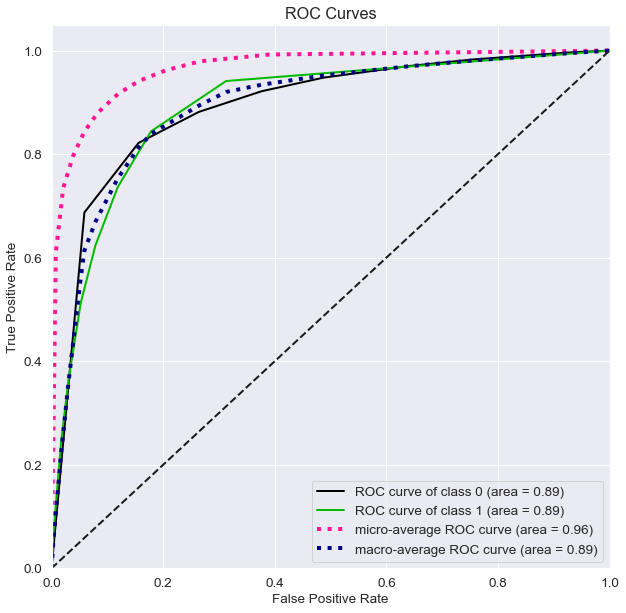

In [22]:
rf=RandomForestClassifier()
rf.fit(X_train, y_train)

predictions=rf.predict(X_test)
predictions_probab = rf.predict_proba(X_test)
cm=confusion_matrix(y_test, predictions)
print('Predicted confusion Matrix:')
print(cm)
print('')
print('Classification Report: ')
labels = ['0', '1']
print(classification_report(y_test, predictions, target_names=labels))
print('')
print('ROC Curve: ')
skplt.metrics.plot_roc_curve(y_test, predictions_probab)
plt.show()

Predicted confusion Matrix:
[[5444  155]
 [ 456  275]]

Classification Report: 
              precision    recall  f1-score   support

           0       0.92      0.97      0.95      5599
           1       0.64      0.38      0.47       731

    accuracy                           0.90      6330
   macro avg       0.78      0.67      0.71      6330
weighted avg       0.89      0.90      0.89      6330


ROC Curve:


C:\Users\siddharthsharma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:85: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


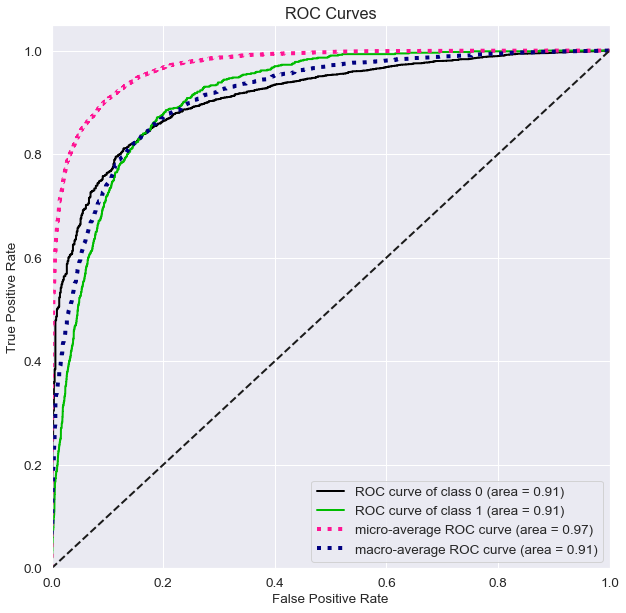

In [23]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

predictions_xgb=xgb.predict(X_test)
predictions_probab_xgb=xgb.predict_proba(X_test)
cm=confusion_matrix(y_test, predictions_xgb)
print('Predicted confusion Matrix:')
print(cm)
print('')
print('Classification Report: ')
labels = ['0', '1']
print(classification_report(y_test, predictions_xgb, target_names=labels))
print('')
print('ROC Curve:')
skplt.metrics.plot_roc_curve(y_test, predictions_probab_xgb)
plt.show()

Let's tweak the parameters using RandomizedSearchCV and optimize out prediction model. I will be doing it for XGBoost. 

In [ ]:
param_grid = {'n_estimators': [10, 40, 60, 80, 100],
                    'learning_rate': [0.06, 0.02, 0.1, 0.15],
                    'gamma':  [0.03, 0.04, 0.05, 0.09],
                    'max_delta_step': [10, 20, 6, 8],
                    'max_depth':[2, 6, 10, 15]}       

In [ ]:
start = time()
clf = RandomizedSearchCV(xgb, n_iter = 500, param_distributions=param_grid, cv=3, n_jobs=-1, verbose=2)
clf.fit(X_train, y_train)

In [ ]:
print("RandomizedSearchCV took %.2f seconds." % (time() - start))
clf.best_score_, clf.best_params_

Predicted confusion Matrix:
[[5389  210]
 [ 396  335]]

Classification Report: 
              precision    recall  f1-score   support

           0       0.93      0.96      0.95      5599
           1       0.61      0.46      0.53       731

    accuracy                           0.90      6330
   macro avg       0.77      0.71      0.74      6330
weighted avg       0.89      0.90      0.90      6330


ROC Curve:


C:\Users\siddharthsharma\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:85: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


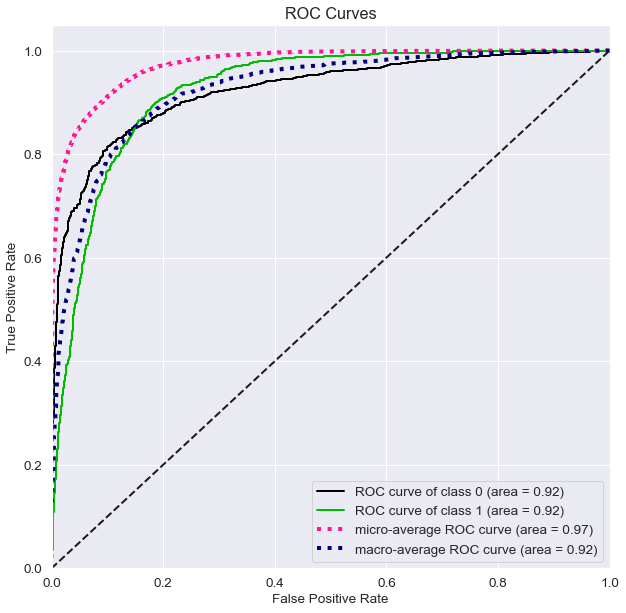

In [24]:
xgb = XGBClassifier(n_estimators=100, max_depth=6, max_delta_step=10, learning_rate=0.1, gamma=0.05)
xgb.fit(X_train, y_train)

predictions_xgb=xgb.predict(X_test)
predictions_probab_xgb=xgb.predict_proba(X_test)
cm=confusion_matrix(y_test, predictions_xgb)
print('Predicted confusion Matrix:')
print(cm)
print('')
print('Classification Report: ')
labels = ['0', '1']
print(classification_report(y_test, predictions_xgb, target_names=labels))
print('')
print('ROC Curve:')
skplt.metrics.plot_roc_curve(y_test, predictions_probab_xgb)
plt.show()

Gainstable Validation: 

In [26]:
y_pred_probab = xgb.predict_proba(X_train)
y_gain = y_pred_probab[:, 1]
y_gain = list(y_gain)
y_train = list(y_train)
dataframe = pd.DataFrame({'actual': y_train, 'predicted': y_gain})

In [28]:
def get_bins(train, n_bins, case):
    bin_size = int(train.shape[0]/n_bins)
    mini = 0
    lower = []
    upper = []
    list_pred = []
    if case == 1:
        train.sort_values(['predicted'], inplace = True, ascending = True)
        train = train.reset_index(drop=True)
        for k in range (0, n_bins):
            mini = k*bin_size
            if k == n_bins-1:
                for i in range(mini, train.shape[0]):
                    list_pred.append(train['predicted'][i])
                lower.append(min(list_pred))
                upper.append(1)
                list_pred = []
                mini = 0
            
            else:
                for i in range(mini, bin_size*(k+1)):
                    list_pred.append(train['predicted'][i])
                if mini == 0:
                    lower.append(0)
                else:
                    lower.append(min(list_pred))
                upper.append(max(list_pred))
                list_pred = []
                mini = 0 
        return lower, upper
    
    if case == 0:
        train.sort_values(['predicted'], inplace = True, ascending = False)
        train = train.reset_index(drop=True)
        for k in range (0, n_bins):
            mini = k*bin_size
            if k == n_bins-1:
                for i in range(mini, train.shape[0]):
                    list_pred.append(train['predicted'][i])
                upper.append(max(list_pred))
                lower.append(0)
                list_pred = []
                mini = 0
            
            else:
                for i in range(mini, bin_size*(k+1)):
                    list_pred.append(train['predicted'][i])
                if k == 0:
                    upper.append(1)
                else:
                    upper.append(max(list_pred))
                lower.append(min(list_pred))
                list_pred = []
                mini = 0 
        return lower, upper

lower, upper = get_bins(dataframe, 10, 0)
lower1, upper1 = get_bins(dataframe, 10, 1)

def get_gaintable_fixed(lower, upper, n_bins, train, case):
    count = [0]*n_bins
    total_dv1 = [0]*n_bins
    total_non_dv1 = [0]*n_bins
    dv_rate = [0]*n_bins
    cum_dv = []
    cum_perc = []
    total_dv_itr = 0
    total_itr = 0
    if case == 1:
        for j in range(0, n_bins):
            if lower[j] == 0:
                print("x >=", lower[j], "x <=", upper[j])
                for i in range(0, train.shape[0]):
                    if train['predicted'][i] >= lower[j] and train['predicted'][i] <= upper[j]:
                        count[j] += 1
                        if train['actual'][i] == 0:
                            total_non_dv1[j] += 1
                        else:
                            total_dv1[j] += 1
            if lower[j] != 0:
                print("x >", lower[j], "x <=", upper[j])
                for i in range(0, train.shape[0]):
                    if train['predicted'][i] > lower[j] and train['predicted'][i] <= upper[j]:
                        count[j] += 1
                        if train['actual'][i] == 0:
                            total_non_dv1[j] += 1
                        else:
                            total_dv1[j] += 1
                            
            print(count[j])
            dv_rate[j] = total_dv1[j]/count[j]
        df_fixed = pd.DataFrame({'axis1':lower, 'axis2':upper, 'Total':count, 'Total_DV':total_dv1, 'Total_non_DV':total_non_dv1, 'DV_rate':dv_rate}) 
        for i in range((len(count)-1), -1, -1):
            total_dv_itr = total_dv_itr + total_dv1[i]
            total_itr = total_itr + count[i]
            total_perc_no = total_itr/train.shape[0]
            cum_perc.append(total_perc_no)
            cum_dv.append(total_dv_itr/total_itr)     
        cum_dv = cum_dv[::-1]
        df_fixed["CUM_DV"] = cum_dv
        df_fixed["CUM_TOTAL"] = cum_perc
        return df_fixed

    if case == 0:        
        for j in range(0, n_bins):
            if lower[j] == 1:
                print("x <=", lower[j], "x >=", upper[j])
                for i in range(0, train.shape[0]):
                    if train['predicted'][i] <= lower[j] and train['predicted'][i] >= upper[j]:
                        count[j] += 1
                        if train['actual'][i] == 0:
                            total_non_dv1[j] += 1
                        else:
                            total_dv1[j] += 1
            if lower[j] != 1:
                print("x <", lower[j], "x >=", upper[j])
                for i in range(0, train.shape[0]):
                    if train['predicted'][i] < lower[j] and train['predicted'][i] >= upper[j]:
                        count[j] += 1
                        if train['actual'][i] == 0:
                            total_non_dv1[j] += 1
                        else:
                            total_dv1[j] += 1
                        
            print(count[j])
            dv_rate[j] = total_dv1[j]/count[j]
        df_fixed = pd.DataFrame({'axis1':lower, 'axis2':upper, 'Total':count, 'Total_DV':total_dv1, 'Total_non_DV':total_non_dv1, 'DV_rate':dv_rate})         
        for i in range(0, len(count)):
            total_dv_itr = total_dv_itr + total_dv1[i]
            total_itr = total_itr + count[i]
            total_perc_no = total_itr/train.shape[0]
            cum_perc.append(total_perc_no)
            cum_dv.append(total_dv_itr/total_itr)     
        df_fixed["CUM_DV"] = cum_dv
        df_fixed["CUM_TOTAL"] = cum_perc
        return df_fixed
    
    else: 
        print("Invalid case input.")

In [29]:
df1 = get_gaintable_fixed(upper, lower, 10, dataframe, 0)
df1.head(10)

x <= 1 x >= 0.4504806697368622
2531
x < 0.45023202896118164 x >= 0.1881447434425354
2530
x < 0.1880219727754593 x >= 0.07217248529195786
2530
x < 0.0721588209271431 x >= 0.03345947340130806
2530
x < 0.033451344817876816 x >= 0.016916902735829353
2530
x < 0.01691579259932041 x >= 0.008383422158658504
2530
x < 0.008380048908293247 x >= 0.004322148859500885
2531
x < 0.004322148859500885 x >= 0.002442853292450309
2530
x < 0.0024414327926933765 x >= 0.0012378324754536152
2530
x < 0.001237598480656743 x >= 0
2537


,axis1,axis2,Total,Total_DV,Total_non_DV,DV_rate,CUM_DV,CUM_TOTAL
0,1.000000,0.450481,2531,1956,575,0.772817,0.772817,0.099972
1,0.450232,0.188145,2530,739,1791,0.292095,0.532503,0.199905
2,0.188022,0.072172,2530,222,2308,0.087747,0.384271,0.299838
3,0.072159,0.033459,2530,50,2480,0.019763,0.293153,0.399771
4,0.033451,0.016917,2530,10,2520,0.003953,0.235317,0.499704
5,0.016916,0.008383,2530,4,2526,0.001581,0.196364,0.599637
6,0.008380,0.004322,2531,0,2531,0.000000,0.168304,0.699609
7,0.004322,0.002443,2530,0,2530,0.000000,0.147268,0.799542
8,0.002441,0.001238,2530,1,2529,0.000395,0.130950,0.899475
9,0.001238,0.000000,2537,0,2537,0.000000,0.117824,0.999684


In [31]:
y_pred_probab1 = xgb.predict_proba(X_test)
y_gain1 = y_pred_probab1[:, 1]
y_gain1 = list(y_gain1)
y_test = list(y_test)
dataframe1 = pd.DataFrame({'actual': y_test, 'predicted': y_gain1})

In [32]:
df2 = get_gaintable_fixed(upper, lower, 10, dataframe1, 0)
df2.head(10)

x <= 1 x >= 0.4504806697368622
623
x < 0.45023202896118164 x >= 0.1881447434425354
666
x < 0.1880219727754593 x >= 0.07217248529195786
680
x < 0.0721588209271431 x >= 0.03345947340130806
627
x < 0.033451344817876816 x >= 0.016916902735829353
657
x < 0.01691579259932041 x >= 0.008383422158658504
633
x < 0.008380048908293247 x >= 0.004322148859500885
618
x < 0.004322148859500885 x >= 0.002442853292450309
627
x < 0.0024414327926933765 x >= 0.0012378324754536152
607
x < 0.001237598480656743 x >= 0
592


,axis1,axis2,Total,Total_DV,Total_non_DV,DV_rate,CUM_DV,CUM_TOTAL
0,1.000000,0.450481,623,374,249,0.600321,0.600321,0.098420
1,0.450232,0.188145,666,217,449,0.325826,0.458495,0.203633
2,0.188022,0.072172,680,88,592,0.129412,0.344845,0.311058
3,0.072159,0.033459,627,30,597,0.047847,0.273112,0.410111
4,0.033451,0.016917,657,13,644,0.019787,0.221949,0.513902
5,0.016916,0.008383,633,3,630,0.004739,0.186567,0.613902
6,0.008380,0.004322,618,3,615,0.004854,0.161634,0.711532
7,0.004322,0.002443,627,3,624,0.004785,0.142467,0.810585
8,0.002441,0.001238,607,0,607,0.000000,0.127396,0.906477
9,0.001238,0.000000,592,0,592,0.000000,0.115482,1.000000


As you can observe there is no break in the cumulative DV Rate in subsequent bins, always increasing bins indicate model working linearly and positively. A complete funnel is formed. 